# Определение перспективного тарифа для телеком-компании

# Содержание

<a href="#Задача" >Задача</a> <br>
<a href="#Описание-данных" >Описание данных</a> <br>
<a href="#Оценка-входных-данных">Оценка входных данных</a> <br>
<a href="#Предобработка-данных">Предобработка данных</a> <br>
<a href="#Средняя-выручка-пользователей-«Ультра»-и-«Смарт»-из-Москвы-и-других-регионов" >Средняя выручка пользователей «Ультра» и «Смарт» из Москвы и других регионов</a> <br>
<a href="#Cреднее-количество,-дисперсия-и-стандартное-отклонение" >Cреднее количество, дисперсия и стандартное отклонение</a> <br>
<a href="#Проверим-гипотезы" >Проверим гипотезы</a> <br>
<a href="#Общий-вывод" >Общий вывод</a> <br>




## Задача

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
Описание тарифов
Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

N.B «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных

Описание данных
Таблица users (информация о пользователях):

    * user_id — уникальный идентификатор пользователя
    * first_name — имя пользователя
    * last_name — фамилия пользователя
    * age — возраст пользователя (годы)
    * reg_date — дата подключения тарифа (день, месяц, год)
    * churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    * city — город проживания пользователя
    * tarif — название тарифного плана

Таблица calls (информация о звонках):

    * id — уникальный номер звонка
    * call_date — дата звонка
    * duration — длительность звонка в минутах
    * user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    * id — уникальный номер сообщения
    * message_date — дата сообщения
    * user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    * id — уникальный номер сессии
    * mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    * session_date — дата интернет-сессии
    * user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    * tariff_name — название тарифа
    * rub_monthly_fee — ежемесячная абонентская плата в рублях
    * minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    * messages_included — количество сообщений в месяц, включённых в абонентскую плату
    * mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    * rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    * rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    * rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Оценка входных данных

In [1]:
!pip install seaborn
!pip install scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
data_users=pd.read_csv("users.csv")
data_calls=pd.read_csv("calls.csv")
data_messages=pd.read_csv("messages.csv")
data_internet=pd.read_csv("internet.csv")
data_tariffs=pd.read_csv("tariffs.csv")


Ознакомимся с данными.

In [2]:
data_table=[data_users,
data_calls,
data_messages,
data_internet,
data_tariffs]

def series_analise(series):
    print("________________","________________")
    print(series.name)
    try: 
        return f"Для этого столбца Среднеее значение:{series.mean()}" + "\n" + f"Максимальное значение: {series.max()}"+ "\n" + f"Минимальное значение: {series.min()}"+ "\n" + f"Всего наблюдений: {series.count()}" + "\n" + f"Уникальные значения: {series.unique()}"+ "\n" + f"Пропущенные значения: {series.isna().sum()}"
    except:
        return f"Для этого столбца" + "\n" f"Всего наблюдений: {series.count()}" + "\n" + f"Уникальные значения: {series.unique()}" + "\n" + f"Пропущенные значения: {series.isna().sum()}"



for i in data_table:
    i.info()
    print()
    for columns in i.columns:
        print(series_analise(i[columns]))
    print()
    display(i.head(3))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

________________ ________________
user_id
Для этого столбца Среднеее значение:1249.5
Максимальное значение: 1499
Минимальное значение: 1000
Всего наблюдений: 500
Уникальные значения: [1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 10

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

________________ ________________
id
Для этого столбца Среднеее значение:inf
Максимальное значение: 1499_99
Минимальное значение: 1000_0
Всего наблюдений: 202607
Уникальные значения: ['1000_0' '1000_1' '1000_2' ... '1499_217' '1499_218' '1499_219']
Пропущенные значения: 0
________________ ________________
call_date
Для этого столбца
Всего наблюдений: 202607
Уникальные значения: ['2018-07-25' '2018-08-17' '2018-06-11' '2018-09-21' '2018-12-15'
 '2018-11-02' '2018-10-18' '2018-08-22' '2018-09-15' '2018-08-15'
 '2018-05-28' '2018-07-05' '2018-09-29' '2018-12-11' '2018-07-27'
 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

________________ ________________
id
Для этого столбца Среднеее значение:inf
Максимальное значение: 1499_99
Минимальное значение: 1000_0
Всего наблюдений: 123036
Уникальные значения: ['1000_0' '1000_1' '1000_2' ... '1499_181' '1499_182' '1499_183']
Пропущенные значения: 0
________________ ________________
message_date
Для этого столбца
Всего наблюдений: 123036
Уникальные значения: ['2018-06-27' '2018-10-08' '2018-08-04' '2018-06-16' '2018-12-05'
 '2018-06-20' '2018-11-19' '2018-10-29' '2018-06-25' '2018-12-18'
 '2018-05-30' '2018-07-06' '2018-08-20' '2018-10-30' '2018-09-14'
 '2018-08-28' '2018-06-29' '2018-07-07' '

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

________________ ________________
Unnamed: 0
Для этого столбца Среднеее значение:74697.5
Максимальное значение: 149395
Минимальное значение: 0
Всего наблюдений: 149396
Уникальные значения: [     0      1      2 ... 149393 149394 149395]
Пропущенные значения: 0
________________ ________________
id
Для этого столбца Среднеее значение:inf
Максимальное значение: 1499_99
Минимальное значение: 1000_0
Всего наблюдений: 149396
Уникальные значения: ['1000_0' '1000_1' '1000_2' ... '1499_154' '1499_155' '1499_156']
Пропущен

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

________________ ________________
messages_included
Для этого столбца Среднеее значение:525.0
Максимальное значение: 1000
Минимальное значение: 50
Всего наблюдений: 2
Уникальные значения: [  50 1000]
Пропущенные значения: 0
________________ ________________
mb_per_month_included
Для этого столбца Среднеее значение:23040.0
Максималь

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


После анализа выявлены следующие проблемы. 
* Даты необходимо привести к datetime. Для столбцов: ['churn_date', 'call_date', 'reg_date', 'message_date', 'session_date']
* В столбце duration датафрейма data_calls все значения округлить и привести к int.
* В mb_used столбце дата фрейма data_internet значения округлить и привести к int.

### Предобработка данных

Изменим столбцы с неправильным форматом даты.

In [3]:

def to_datetimes(series,dataframe): # Функция для замены формата даты.
    dataframe[series] = pd.to_datetime(dataframe[series], format='%Y-%m-%d')

    
to_datetimes('churn_date',data_users)
to_datetimes('reg_date',data_users)
to_datetimes('call_date',data_calls)
to_datetimes('message_date',data_messages)
to_datetimes('session_date',data_internet)



Исправим столбец duration датасета data_calls.

In [4]:
data_calls['duration'] = data_calls['duration'].apply(np.ceil)
data_calls['duration'].head(10)



0     0.0
1     0.0
2     3.0
3    14.0
4     6.0
5     0.0
6     0.0
7    19.0
8    19.0
9     0.0
Name: duration, dtype: float64

Теперь продолжительноссть соответствует правилу, что нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Так как они теперь целые, приведем их к int.

In [5]:
data_calls['duration']=data_calls['duration'].astype('int')
data_calls['duration'].head(10)

0     0
1     0
2     3
3    14
4     6
5     0
6     0
7    19
8    19
9     0
Name: duration, dtype: int64

В md_used столбце дата фрейма internet_data значения округлим и приведем к int.

In [6]:
data_internet['mb_used'] = data_internet['mb_used']
data_internet['mb_used'].head(10)

0     112.95
1    1052.81
2    1197.26
3     550.27
4     302.56
5     399.97
6     540.08
7     415.70
8     505.40
9     345.54
Name: mb_used, dtype: float64

Предобработка для поставленной задачи выполнена.

### Посчитаем необходимые данные

Добавим в таблицы месяц.
* data_calls
* data_messages
* data_internet

In [7]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month
display(
    data_messages.head(10), 
    data_calls.head(10),
    data_internet.head(10)
    )

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
5,5,1000_5,399.97,2018-10-02,1000,10
6,6,1000_6,540.08,2018-09-07,1000,9
7,7,1000_7,415.70,2018-07-11,1000,7
8,8,1000_8,505.40,2018-10-08,1000,10
9,9,1000_9,345.54,2018-09-03,1000,9


Создадим таблицы с расчетами для каждого пользователя по месяцам:
* Количество звонков,длительность.
* Сообщения.
* Трафик

In [8]:
calls_month_table = data_calls.pivot_table(index=['month','user_id'],
                             values='duration',
                             aggfunc=['count', 'sum'])

calls_month=pd.DataFrame(calls_month_table.to_records())
calls_month.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   month                  3174 non-null   int64
 1   user_id                3174 non-null   int64
 2   ('count', 'duration')  3174 non-null   int64
 3   ('sum', 'duration')    3174 non-null   int64
dtypes: int64(4)
memory usage: 99.3 KB


In [9]:
messages_month_table = data_messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count')
messages_month=pd.DataFrame(messages_month_table.to_records())
messages_month.head(15)


,month,user_id,id
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
5,1,1113,14
6,1,1126,4
7,1,1134,32
8,1,1135,1
9,1,1155,48


In [10]:
internet_month_table = data_internet.pivot_table(index=['month', 'user_id'],
                                         values='mb_used',
                                         aggfunc='sum')
internet_month=pd.DataFrame(internet_month_table.to_records())
internet_month.head(10)

,month,user_id,mb_used
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34
5,1,1113,766.22
6,1,1120,656.75
7,1,1126,16363.03
8,1,1134,10200.01
9,1,1135,1600.28


Из созданных таблиц, создадим датафрейм с месячными расходами трафика по id.

In [11]:





monthly_trafick=calls_month.merge(internet_month, on=['user_id', 'month'], how='outer')
monthly_trafick=monthly_trafick.rename(columns={"mb_used":"internet","('sum', 'duration')": 'minutes',"('count', 'duration')":"cals"})
monthly_trafick=monthly_trafick.merge(messages_month, on=['user_id', 'month'], how='outer')
monthly_trafick=monthly_trafick.rename(columns={"id":"messages"})
monthly_trafick



,month,user_id,cals,minutes,internet,messages
0,1,1005,15.0,95.0,2727.97,7.0
1,1,1032,61.0,380.0,24127.69,38.0
2,1,1045,1.0,9.0,2346.71,5.0
3,1,1055,64.0,551.0,17090.88,30.0
4,1,1071,24.0,194.0,15604.34,16.0
...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0
3210,12,1231,NaN,NaN,32448.00,191.0
3211,12,1328,NaN,NaN,39419.73,7.0
3212,12,1473,NaN,NaN,18418.26,20.0


Добавим в таблицу тарифы абонентов города, необходимые для расчетов.

In [12]:
monthly_trafick=monthly_trafick.merge(data_users.loc[:, ['tariff','user_id','city']],on="user_id",how='left')
monthly_trafick

,month,user_id,cals,minutes,internet,messages,tariff,city
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск
...,...,...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0,ultra,Калуга
3210,12,1231,NaN,NaN,32448.00,191.0,ultra,Чебоксары
3211,12,1328,NaN,NaN,39419.73,7.0,ultra,Мурманск
3212,12,1473,NaN,NaN,18418.26,20.0,ultra,Красноярск


Через тариф добавим в таблицу нормы расхода, необходимые для расчета. Для этого переименуем столбец названия тарифа в data_tariffs на tariff.

In [13]:
data_tariffs = data_tariffs.rename(columns={'tariff_name': 'tariff'})
monthly_trafick=monthly_trafick.merge(data_tariffs,on="tariff",how='left')
monthly_trafick

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0,ultra,Калуга,1000,30720,3000,1950,150,1,1
3210,12,1231,NaN,NaN,32448.00,191.0,ultra,Чебоксары,1000,30720,3000,1950,150,1,1
3211,12,1328,NaN,NaN,39419.73,7.0,ultra,Мурманск,1000,30720,3000,1950,150,1,1
3212,12,1473,NaN,NaN,18418.26,20.0,ultra,Красноярск,1000,30720,3000,1950,150,1,1


Рассчитаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [14]:
monthly_trafick['minutes_price']=monthly_trafick['minutes_included']-monthly_trafick['minutes']
monthly_trafick['messages_price']=monthly_trafick['messages_included']-monthly_trafick['messages']
monthly_trafick['internet_price']=monthly_trafick['mb_per_month_included']-monthly_trafick['internet']
monthly_trafick

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3,405.0,43.0,12632.03
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3,120.0,12.0,-8767.69
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3,491.0,45.0,13013.29
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3,-51.0,20.0,-1730.88
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3,306.0,34.0,-244.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0,ultra,Калуга,1000,30720,3000,1950,150,1,1,NaN,976.0,12018.49
3210,12,1231,NaN,NaN,32448.00,191.0,ultra,Чебоксары,1000,30720,3000,1950,150,1,1,NaN,809.0,-1728.00
3211,12,1328,NaN,NaN,39419.73,7.0,ultra,Мурманск,1000,30720,3000,1950,150,1,1,NaN,993.0,-8699.73
3212,12,1473,NaN,NaN,18418.26,20.0,ultra,Красноярск,1000,30720,3000,1950,150,1,1,NaN,980.0,12301.74


Расход денег на минуты. Отрицательные значения - это перерасход трафика. Значит, если значение отрицательное, модуль числа надо умножить на цену минуты сверх абонентской платы. Создадим функцию для обработки минут.

In [15]:
def minutes_to_rub(row):
    minutes_price = row['minutes_price']
    if minutes_price < 0:
        return abs(row['minutes_price'])*row['rub_per_minute']
    else:
        return 0

monthly_trafick['minutes_price']=monthly_trafick.apply(minutes_to_rub,axis=1)
monthly_trafick

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3,0.0,43.0,12632.03
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3,0.0,12.0,-8767.69
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3,0.0,45.0,13013.29
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3,153.0,20.0,-1730.88
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3,0.0,34.0,-244.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0,ultra,Калуга,1000,30720,3000,1950,150,1,1,0.0,976.0,12018.49
3210,12,1231,NaN,NaN,32448.00,191.0,ultra,Чебоксары,1000,30720,3000,1950,150,1,1,0.0,809.0,-1728.00
3211,12,1328,NaN,NaN,39419.73,7.0,ultra,Мурманск,1000,30720,3000,1950,150,1,1,0.0,993.0,-8699.73
3212,12,1473,NaN,NaN,18418.26,20.0,ultra,Красноярск,1000,30720,3000,1950,150,1,1,0.0,980.0,12301.74


Расход денег на смс. Отрицательные значения - это перерасход трафика. Значит, если значение отрицательное, модуль числа надо умножить на цену сообщения сверх абонентской платы. Создадим функцию для обработки сообщений.

In [16]:
def messages_to_rub(row):
    messages_price = row['messages_price']
    if messages_price < 0:
        return abs(row['messages_price'])*row['rub_per_message']
    else:
        return 0

monthly_trafick['messages_price']=monthly_trafick.apply(messages_to_rub,axis=1)
monthly_trafick

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3,0.0,0.0,12632.03
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3,0.0,0.0,-8767.69
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3,0.0,0.0,13013.29
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3,153.0,0.0,-1730.88
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3,0.0,0.0,-244.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,NaN,NaN,18701.51,24.0,ultra,Калуга,1000,30720,3000,1950,150,1,1,0.0,0.0,12018.49
3210,12,1231,NaN,NaN,32448.00,191.0,ultra,Чебоксары,1000,30720,3000,1950,150,1,1,0.0,0.0,-1728.00
3211,12,1328,NaN,NaN,39419.73,7.0,ultra,Мурманск,1000,30720,3000,1950,150,1,1,0.0,0.0,-8699.73
3212,12,1473,NaN,NaN,18418.26,20.0,ultra,Красноярск,1000,30720,3000,1950,150,1,1,0.0,0.0,12301.74


Расход денег на интернет. Отрицательные значения - это перерасход трафика. Значит, если значение отрицательное, модуль числа надо разделить на 1000 и умножить на цену 1гб сверх абонентской платы. Создадим функцию для обработки интернеттрафика.

In [17]:
def internet_to_rub(row):
    internet_price = row['internet_price']
    if internet_price < 0:
        return np.ceil(abs(row['internet_price']))/1024*row['rub_per_gb']
    else:
        return 0

monthly_trafick['internet_price']=monthly_trafick.apply(internet_to_rub,axis=1)
monthly_trafick['internet_price']=monthly_trafick['internet_price'].astype('int')
monthly_trafick.head(30)

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3,0.0,0.0,0
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3,0.0,0.0,1712
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3,0.0,0.0,0
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3,153.0,0.0,338
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3,0.0,0.0,47
5,1,1113,18.0,110.0,766.22,14.0,smart,Чита,50,15360,500,550,200,3,3,0.0,0.0,0
6,1,1120,5.0,55.0,656.75,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
7,1,1126,35.0,272.0,16363.03,4.0,ultra,Санкт-Петербург,1000,30720,3000,1950,150,1,1,0.0,0.0,0
8,1,1134,42.0,332.0,10200.01,32.0,smart,Красноярск,50,15360,500,550,200,3,3,0.0,0.0,0
9,1,1135,9.0,90.0,1600.28,1.0,smart,Архангельск,50,15360,500,550,200,3,3,0.0,0.0,0


Добавим общую сууму расходов абонентов в месяц.


In [18]:
monthly_trafick['total_price']=monthly_trafick['internet_price']+monthly_trafick['messages_price']+monthly_trafick['minutes_price']+monthly_trafick['rub_monthly_fee']
monthly_trafick.info()
monthly_trafick=monthly_trafick.fillna(value=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  3214 non-null   int64  
 1   user_id                3214 non-null   int64  
 2   cals                   3174 non-null   float64
 3   minutes                3174 non-null   float64
 4   internet               3203 non-null   float64
 5   messages               2717 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
 15  minu

In [19]:
monthly_trafick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  3214 non-null   int64  
 1   user_id                3214 non-null   int64  
 2   cals                   3214 non-null   float64
 3   minutes                3214 non-null   float64
 4   internet               3214 non-null   float64
 5   messages               3214 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
 15  minu

### Данные готовы к дальнейшему анализу.

In [20]:
monthly_trafick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  3214 non-null   int64  
 1   user_id                3214 non-null   int64  
 2   cals                   3214 non-null   float64
 3   minutes                3214 non-null   float64
 4   internet               3214 non-null   float64
 5   messages               3214 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
 15  minu

Сделаем таблицу по тарифам и среднмесячным показателям минут, сообщений, мегабайтов.


In [21]:
tariff_month_mean = monthly_trafick.pivot_table(index='tariff', values=['minutes', 'messages', 'internet'], aggfunc='mean')
tariff_month_mean

,internet,messages,minutes
tariff,,,
smart,16208.386990,33.384029,417.934948
ultra,19468.805208,49.363452,526.623350


#### В целом пользователи тарифа ультра потребляют больше услуг (больше интернет трафика и звонков). Обращает на себя внимание, что оба тарифа не выполняют в среднем норму сообщений.

Сделаем таблицу по тарифам и средние потраченные деньги на связь.

In [22]:
tariff_month_price_mean = monthly_trafick.pivot_table(index='tariff', values=['total_price'], aggfunc='mean')
tariff_month_price_mean

,total_price
tariff,
smart,1230.205025
ultra,2059.810152


#### Пользователи тарифа ультра выходят за абонентскую плату реже, но платят все равно больше. Пользователи тарифа смарт тратят на связь меньше, чем пользователи тарифа ультра. При  этом большую часть суммы чаще всего составляет плата за превышение лимитов абонетской платы.


### Средняя выручка пользователей «Ультра» и «Смарт» из Москвы и других регионов

Сделаем срезы для Москвы и других регионов.

In [23]:
monthly_trafick_msk=monthly_trafick.query("city=='Москва'")
monthly_trafick_not_msk=monthly_trafick.query("city!='Москва'")
display(monthly_trafick_msk,monthly_trafick_not_msk)

,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price,total_price
15,1,1204,50.0,305.0,15829.77,0.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,91,641.0
19,1,1254,59.0,466.0,19685.01,0.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
23,1,1308,28.0,250.0,11962.84,24.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,0,550.0
30,1,1381,59.0,382.0,14791.37,32.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
31,1,1385,34.0,270.0,19280.10,72.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,12,1461,109.0,821.0,25100.05,76.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
3153,12,1476,81.0,588.0,14121.34,11.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
3157,12,1481,52.0,356.0,16458.96,19.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,214,764.0
3165,12,1490,42.0,290.0,15785.74,46.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,83,633.0


,month,user_id,cals,minutes,internet,messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_price,messages_price,internet_price,total_price
0,1,1005,15.0,95.0,2727.97,7.0,smart,Набережные Челны,50,15360,500,550,200,3,3,0.0,0.0,0,550.0
1,1,1032,61.0,380.0,24127.69,38.0,smart,Ульяновск,50,15360,500,550,200,3,3,0.0,0.0,1712,2262.0
2,1,1045,1.0,9.0,2346.71,5.0,smart,Улан-Удэ,50,15360,500,550,200,3,3,0.0,0.0,0,550.0
3,1,1055,64.0,551.0,17090.88,30.0,smart,Казань,50,15360,500,550,200,3,3,153.0,0.0,338,1041.0
4,1,1071,24.0,194.0,15604.34,16.0,smart,Омск,50,15360,500,550,200,3,3,0.0,0.0,47,597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1106,0.0,0.0,18701.51,24.0,ultra,Калуга,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0
3210,12,1231,0.0,0.0,32448.00,191.0,ultra,Чебоксары,1000,30720,3000,1950,150,1,1,0.0,0.0,253,2203.0
3211,12,1328,0.0,0.0,39419.73,7.0,ultra,Мурманск,1000,30720,3000,1950,150,1,1,0.0,0.0,1274,3224.0
3212,12,1473,0.0,0.0,18418.26,20.0,ultra,Красноярск,1000,30720,3000,1950,150,1,1,0.0,0.0,0,1950.0


Средние показатели расхода трафика для Москвы и регионов.

In [24]:
tariff_month_mean_msk_total = monthly_trafick_msk.pivot_table(index='tariff', values=['minutes', 'messages', 'internet'], aggfunc='mean')
tariff_month_mean_not_msk_total = monthly_trafick_not_msk.pivot_table(index='tariff', values=['minutes', 'messages', 'internet'], aggfunc='mean')
display('____МОСКВА____',tariff_month_mean_msk_total,'____РЕГИОНЫ____',tariff_month_mean_not_msk_total)

'____МОСКВА____'

,internet,messages,minutes
tariff,,,
smart,16018.111632,27.772021,417.481865
ultra,21301.936311,55.213333,557.791111


'____РЕГИОНЫ____'

,internet,messages,minutes
tariff,,,
smart,16248.238475,34.559414,418.029843
ultra,18926.101921,47.631579,517.396053


In [25]:
tariff_month_mean_msk_price = monthly_trafick_msk.pivot_table(index='tariff', values=['total_price'], aggfunc='mean')
tariff_month_mean_not_msk_price = monthly_trafick_not_msk.pivot_table(index='tariff', values=['total_price'], aggfunc='mean')
display('____МОСКВА____',tariff_month_mean_msk_price,'____РЕГИОНЫ____',tariff_month_mean_not_msk_price)

'____МОСКВА____'

,total_price
tariff,
smart,1180.000000
ultra,2062.786667


'____РЕГИОНЫ____'

,total_price
tariff,
smart,1240.720022
ultra,2058.928947


[Text(0.5, 0, 'Расходы на связь в Москве'), Text(0, 0.5, 'Тарифы')]

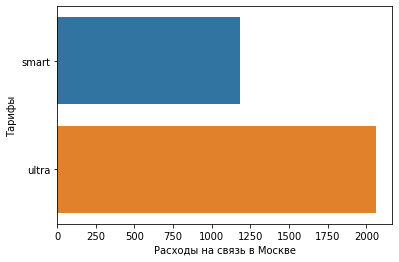

In [26]:
sns.barplot(x=tariff_month_mean_msk_price['total_price'],y=tariff_month_mean_msk_price.index).set(xlabel='Расходы на связь в Москве', ylabel='Тарифы') #Рисуем график для наглядности.

[Text(0.5, 0, 'Расходы на связь в регионах'), Text(0, 0.5, 'Тарифы')]

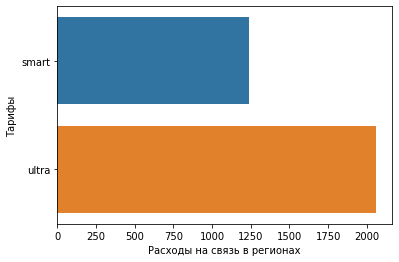

In [27]:
sns.barplot(x=tariff_month_mean_not_msk_price['total_price'],y=tariff_month_mean_not_msk_price.index).set(xlabel='Расходы на связь в регионах', ylabel='Тарифы') #Рисуем график для наглядности.

#### Поведение абонентов в Москве и регионах отличаеться но не значительно.
* В Москве пользователи расходуют больше интернет трафика.
* В Москве пользователи тарифов тратят несколько больше, чем в регионах. Это особенно заметно на тарифе смарт, вероятно, за счет дополнительного интернет трафика.

### Cреднее количество, дисперсия и стандартное отклонение

In [28]:
smart = monthly_trafick.query("tariff == 'smart'") # срезы для тарифов.
ultra = monthly_trafick.query("tariff == 'ultra'") # срезы для тарифов.

#### Минуты

In [29]:
display(
    smart['minutes'].describe(),
    ultra['minutes'].describe()
    )
print("Вычислим дисперсию затрат минут тарифов смарт и ультра минуты" )
display(
    np.var(smart['minutes']),
    np.var(ultra['minutes'])
    )


count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: minutes, dtype: float64

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes, dtype: float64

Вычислим дисперсию затрат минут тарифов смарт и ультра минуты


36203.06665209469

100771.2236172022

#### Сообщения

In [30]:
display(
    smart['messages'].describe(),
    ultra['messages'].describe()
    )
print("Вычислим дисперсию затрат для тарифов смарт и ультра сообщения")
display(
    np.var(smart['messages']),
    np.var(ultra['messages'])
    )

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

Вычислим дисперсию затрат для тарифов смарт и ультра сообщения


796.455482917076

2282.9460753948824

#### Интернет трафик

In [31]:
display(
    smart['internet'].describe(),
    ultra['internet'].describe()
    )
print("Вычислим дисперсию затрат тарифов смарт и ультра интернет")
display(
    np.var(smart['internet']),
    np.var(ultra['internet'])
    )

count     2229.000000
mean     16208.386990
std       5870.476681
min          0.000000
25%      12643.010000
50%      16506.840000
75%      20042.930000
max      38552.450000
Name: internet, dtype: float64

count      985.000000
mean     19468.805208
std      10087.170752
min          0.000000
25%      11770.260000
50%      19308.010000
75%      26837.690000
max      49745.690000
Name: internet, dtype: float64

Вычислим дисперсию затрат тарифов смарт и ультра интернет


34447035.49528492

101647713.26174638

#### Гистограммы

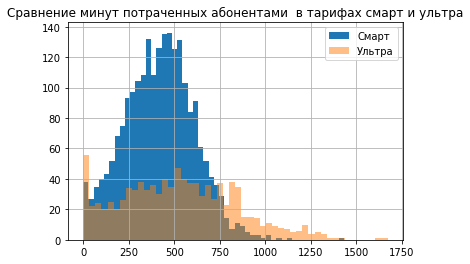

In [32]:
plt.title('Сравнение минут потраченных абонентами  в тарифах смарт и ультра')
smart['minutes'].hist(bins=50,label='Смарт')
ultra['minutes'].hist(bins=50,label='Ультра', alpha=0.5)
plt.legend(loc='upper right')

* Абоненты тарифа смарт чаще расходуют лимит тарифа и расходуют минуты сверх. 
* Абоненты тарифа ультра почти не выходят за лимиты. 
* В целом абоненты тарифа смарт тратят меньше времени на разговоры по мобильному.

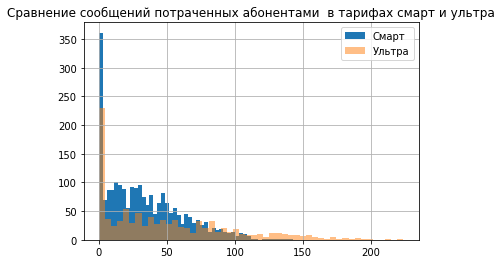

In [33]:
plt.title('Сравнение сообщений потраченных абонентами  в тарифах смарт и ультра')
smart['messages'].hist(bins=50,label='Смарт')
ultra['messages'].hist(bins=50,label='Ультра', alpha=0.5)
plt.legend(loc='upper right')

* Абоненты тарифа смарт в целом отправляют меньше сообщений. 
* Абоненты тарифа смарт чаще выходят за лимит сообщений.
* Абоненты тарифа смарт чаще не пользуются сообщениями.
* Абоненты тарифа ультра не выходят за лимит сообщений.


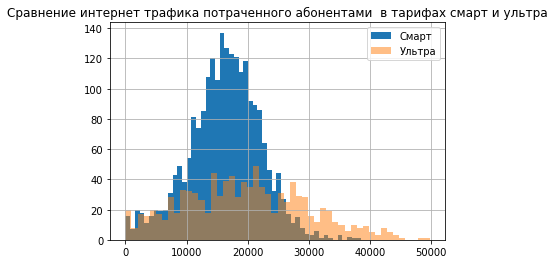

In [34]:
plt.title('Сравнение интернет трафика потраченного абонентами  в тарифах смарт и ультра')
smart['internet'].hist(bins=50,label='Смарт')
ultra['internet'].hist(bins=50,label='Ультра', alpha=0.5)
plt.legend(loc='upper right')

* Больше половины абонентов тарифа смарт выходят за лимит интернета в 15 гб.
* Абоненты тарифа ультра выходят за лемит значительно реже.

### Проверим гипотезы

#### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

* H0 Будет звучать как: Cредняя выручка пользователей тарифов смарт и ультра не различается;
* H1 Будет звучать как: Cредняя выручка пользователей тарифов смарт и ультра различаются;

In [35]:
alpha = .05
result = st.ttest_ind(
    smart['total_price'], 
    ultra['total_price'])
print('p-значение:', result.pvalue)
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: Cредняя выручка пользователей тарифов смарт и ультра не различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу: Cредняя выручка пользователей тарифов смарт и ультра не различаются")


p-значение: 1.471403217541362e-192
Отвергаем нулевую гипотезу: Cредняя выручка пользователей тарифов смарт и ультра не различается


#### Средняя выручка тарифов смарт и ультра одназначно различаются.

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
* H0 Будет звучать как: Средняя выручка пользователей из Москвы и выручка пользователей из других регионов не различаются;
* H1 Будет звучать как: Средняя выручка пользователей из Москвы и выручка пользователей из других регионов различаются;

In [36]:
alpha = .05
results_city = st.ttest_ind(monthly_trafick[monthly_trafick["city"]=='Москва']['total_price'], monthly_trafick[monthly_trafick["city"]!='Москва']['total_price'],equal_var = False)
print('p-значение:', results_city.pvalue)
if results_city.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не можем отвергнуть нулевую гипотезу.')


p-значение: 0.44977638864778025
Не можем отвергнуть нулевую гипотезу.


In [37]:
print(
    monthly_trafick.query("city=='Москва'")['total_price'].mean(),
    monthly_trafick.query("city!='Москва'")['total_price'].mean()
    )

1505.0851063829787 1479.6131386861314


#### Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

### Проанализировав данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год, пришел к следующим выводам.
* Для компании одназначно более выгоден тариф ультра, средняя выручка больше.
* Для пользователей тариф смарт более выгоден, даже при разумном превышении лимитов.
* Пользователи тарифа смарт чаще выходят за лимиты сообщений, звонков и интернета, но всеравно платят за связь в целом меньше.
* Пользователи Москвы больше пользуються интернетом, чем  в регионах.
* Средняя выручка в Москве не больше чем в регионах.

### Больше рекламы тарифу ультра. Рекламный бюджет надо равномерно распределять между регионами и столицей.